In [ ]:
import os
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import hypergraphx as hgx

from tqdm.notebook import tqdm

from tqdm.auto import tqdm
tqdm.pandas()

import sys
sys.path += ['../']

from src.plot_configs import w_inc_fullpage, h_inc, set_plot_configs
set_plot_configs()

from src.filters import get_svmis

FIG_FOLD = "../paper/figures/"
if not os.path.exists(FIG_FOLD):
    os.makedirs(FIG_FOLD)


In [2]:
def load_walmart():
    """ Load Walmart Trips dataset and return a hypergraph object.
    """
    # Note: nodes in the hyperedges are from 1 to N, while in the other tables indexes start from 0
    # we make nodes go from 0 to N-1 when reading hyperedges

    # in the following two tables, indexes start from 0, so we add 1 to have node IDs from 1 to N
    # (category_id, category_name)
    categories_df = pd.read_csv('../data/walmart-trips/label-names-walmart-trips.txt', sep=';', header=None, names=["category_name"]).reset_index(names='category_id')

    # (node_id, category_id)
    node_categories_df = pd.read_csv('../data/walmart-trips/node-labels-walmart-trips.txt', sep=';', header=None, names=['category_id'])
    node_categories_df.category_id -= 1

    node_categories_df = node_categories_df.merge(categories_df, on='category_id')

    # create hypergraph
    H = hgx.Hypergraph(weighted=True)
    with open('../data/walmart-trips/hyperedges-walmart-trips.txt', 'r') as f:
        for line in f:
            nodes = list(sorted(map(lambda x: int(x) - 1, line.strip().split(','))))

            if H.check_edge(nodes):
                # increment the weight of the edge
                curr_weight = H.get_weight(nodes)
                H.set_weight(nodes, curr_weight + 1)
            else:
                H.add_edge(nodes, weight=1)
                
    # add node metadata
    for node in H.get_nodes():
        node_meta = node_categories_df.loc[node]
        H.set_attr_to_node_metadata(node, "category_id", node_meta['category_id'])
        H.set_attr_to_node_metadata(node, "category_name", node_meta['category_name'])

    return H



### Walmart dataset

In [3]:
H = load_walmart()

print("Number of nodes: ", H.num_nodes())
print("Number of hyperedges: ", H.num_edges())
print("Number of shopping baskets: ", sum(H.get_weights()))

Number of nodes:  88860
Number of hyperedges:  65979
Number of shopping baskets:  69906


In [4]:
# get all categories
all_categories = set([meta["category_name"] for node, meta in H.get_nodes(metadata=True).items()])
n_categories = len(all_categories)

print("Number of categories: ", n_categories)

Number of categories:  11


Consider only hyperedges of size 10 at most.

In [5]:
# remove hyperedges of size > 10
H_cut = H.copy()

for size in range(11, H_cut.max_size() + 1):
    for edge in H_cut.get_edges(size=size):
        H_cut.remove_edge(edge)

# remove isolated nodes
for node in H_cut.isolated_nodes():
    H_cut.remove_node(node)

print("Number of nodes after cutting: ", H_cut.num_nodes())
print("Number of hyperedges after cutting: ", H_cut.num_edges())
print("Number of shopping baskets after cutting: ", sum(H_cut.get_weights()))

Number of nodes after cutting:  69156
Number of hyperedges after cutting:  52383
Number of shopping baskets after cutting:  56308


In [6]:
# extract svmis
svmis_df = get_svmis(H_cut, min_size=2, max_size=10, alpha=0.01, approximate=True)
svmis_df = pd.concat(svmis_df).reset_index(drop=True)

# compute sizes and the count of categories in each svmis
svmis_df.loc[:, "size"] = svmis_df.group.apply(len)
svmis_df.loc[:, "categs_count"] = svmis_df.group.apply(lambda g: Counter([H_cut.get_node_metadata(n)["category_id"] for n in g]))

  0%|          | 0/8 [00:00<?, ?it/s]

In [7]:
svmis_df.head()

,group,pvalue,fdr,size,categs_count
0,"(15, 16, 17, 18, 19, 20, 21, 22, 23, 24)",1.295522e-32,False,10,"{6: 7, 10: 3}"
1,"(122, 170, 171, 172, 173, 174, 175, 176, 177, ...",1.752402e-32,False,10,"{10: 4, 4: 5, 7: 1}"
2,"(281, 282, 283, 284, 285, 286, 287, 288, 289, ...",5.388124e-31,False,10,"{7: 4, 6: 6}"
3,"(56, 97, 525, 526, 527, 528, 529, 530, 531, 532)",2.797011e-29,False,10,"{6: 9, 10: 1}"
4,"(757, 758, 759, 760, 761, 762, 763, 764, 765, ...",1.038748e-33,False,10,"{0: 4, 10: 1, 6: 5}"


In [8]:
# compute purity for svh and svmis
def purity(counter):

    n = sum(counter.values())

    return n / (n - 1) * (1 - len(counter) / n)

svmis_df.loc[:, "purity"] = svmis_df.categs_count.apply(purity)

In [9]:
svmis_df.shape[0], svmis_df.query("fdr").shape[0]

(5197577, 1031)

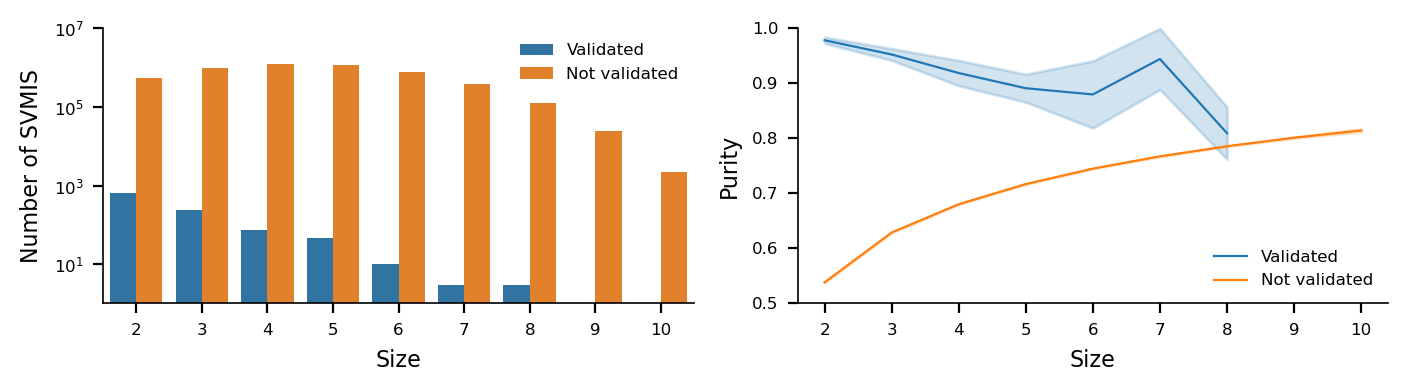

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(w_inc_fullpage, h_inc))

ax = axs[0]
sns.countplot(data=svmis_df, x="size", hue="fdr", hue_order=[True, False], ax=ax)

ax.set_yscale("log")
ax.set_ylim(1, 1e7)
ax.set_yticks([1e1, 1e3, 1e5, 1e7])

# remove minor thicks from y axis
ax.yaxis.set_minor_locator(plt.NullLocator())

ax.set_ylabel("Number of SVMIS")
ax.set_xlabel("Size")

ax = axs[1]
sns.lineplot(data=svmis_df, x="size", y="purity", hue="fdr", hue_order=[True, False], estimator="mean", errorbar="se", ax=ax)

ax.set_ylim(0.5, 1.0)
ax.set_ylabel("Purity")
ax.set_xlabel("Size")

# remove spines and add legend
for ax, leg_loc in zip(axs, ["upper right", "lower right"]):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    handles, _ = ax.get_legend_handles_labels()
    ax.legend(handles=handles, labels=["Validated", "Not validated"], loc=leg_loc, title=None, frameon=False)

fig.tight_layout()

fig_file_name = os.path.join(FIG_FOLD, "WalmartAll_SVMIS.pdf")
if not os.path.exists(fig_file_name):
    fig.savefig(fig_file_name, dpi=300, bbox_inches='tight')